# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações

In [18]:
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

## Configurações

In [19]:
# Configurações globais
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('seaborn-v0_8-whitegrid')
print(f"Usando dispositivo: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cpu


## Dados

In [20]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform_base, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform_base, download=True
)

print(f"Dataset de treino completo: {len(full_train_dataset)} amostras")
print(f"Dataset de teste completo: {len(full_test_dataset)} amostras")

Dataset de treino completo: 60000 amostras
Dataset de teste completo: 10000 amostras


## Modelo Base e funções auxiliares

In [21]:
class BaseModel(nn.Module):
    """Modelo base flexível com dropout configurável."""
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [22]:
def run_experiment(model, train_loader, val_loader, lr=0.001, num_epochs=30, l1_lambda=0.0, l2_lambda=0.0, early_stopping_patience=None):
    """
    Função de treinamento generalizada.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            if l1_lambda > 0:
                l1_penalty = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()

            train_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(100 * train_correct / train_total)
        history['val_acc'].append(100 * val_correct / val_total)

        print(f'Época [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {history["train_acc"][-1]:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {history["val_acc"][-1]:.2f}%')

        if early_stopping_patience is not None:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_no_improve = 0
                best_model_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= early_stopping_patience:
                print(f"\nEarly stopping ativado na época {epoch + 1}!")
                model.load_state_dict(best_model_state)

                break

    return history

In [23]:
def plot_learning_curves(histories, title):
    """
    Plota as curvas de aprendizado para um ou mais experimentos.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(title, fontsize=16)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i, (name, history) in enumerate(histories.items()):
        color = colors[i % len(colors)]
        epochs = range(1, len(history['train_loss']) + 1)
        ax1.plot(epochs, history['train_loss'], color=color, linestyle='--', label=f'{name} - Treino')
        ax1.plot(epochs, history['val_loss'], color=color, linestyle='-', label=f'{name} - Validação')
        ax2.plot(epochs, history['train_acc'], color=color, linestyle='--', label=f'{name} - Treino')
        ax2.plot(epochs, history['val_acc'], color=color, linestyle='-', label=f'{name} - Validação')

    ax1.set_title('Curvas de Perda');
    ax1.set_xlabel('Época');
    ax1.set_ylabel('Perda');
    ax1.legend();
    ax1.grid(True)

    ax2.set_title('Curvas de Acurácia');
    ax2.set_xlabel('Época');
    ax2.set_ylabel('Acurácia (%)');
    ax2.legend();
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]);
    plt.show()

In [24]:
def show_augmented_samples(original_subset, augmented_subset, title="Originais vs. Aumentadas"):
    """Mostra comparação entre amostras originais e aumentadas."""
    fig, axes = plt.subplots(2, 8, figsize=(15, 4)); fig.suptitle(title, fontsize=16)
    indices = np.random.choice(len(original_subset), 8, replace=False)
    for i, idx in enumerate(indices):
        orig_img, label = original_subset[idx]
        aug_img, _ = augmented_subset[idx]
        for ax, img, t in zip([axes[0, i], axes[1, i]], [orig_img, aug_img], [f'Original ({label})', 'Aumentada']):
            img = img * 0.3081 + 0.1307
            ax.imshow(img.squeeze(), cmap='gray'); ax.set_title(t); ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.92]); plt.show()

## Exercícios

### Exercício 1: Experimentação com Hyperparâmetros
Teste diferentes valores de dropout rate e compare os resultados. Qual valor funciona melhor para este dataset?


--- Treinando com Dropout Baseline = 0.0 ---
Época [1/30] - Train Loss: 0.8763, Train Acc: 72.97% | Val Loss: 0.4056, Val Acc: 87.50%
Época [2/30] - Train Loss: 0.3529, Train Acc: 89.22% | Val Loss: 0.3477, Val Acc: 89.70%
Época [3/30] - Train Loss: 0.2260, Train Acc: 93.47% | Val Loss: 0.2765, Val Acc: 92.10%
Época [4/30] - Train Loss: 0.1596, Train Acc: 95.28% | Val Loss: 0.2744, Val Acc: 91.20%
Época [5/30] - Train Loss: 0.1274, Train Acc: 95.90% | Val Loss: 0.2270, Val Acc: 93.20%
Época [6/30] - Train Loss: 0.0688, Train Acc: 98.28% | Val Loss: 0.2257, Val Acc: 93.30%
Época [7/30] - Train Loss: 0.0463, Train Acc: 98.85% | Val Loss: 0.2295, Val Acc: 93.90%
Época [8/30] - Train Loss: 0.0359, Train Acc: 99.20% | Val Loss: 0.2183, Val Acc: 93.40%
Época [9/30] - Train Loss: 0.0190, Train Acc: 99.78% | Val Loss: 0.2348, Val Acc: 92.80%
Época [10/30] - Train Loss: 0.0168, Train Acc: 99.75% | Val Loss: 0.2317, Val Acc: 93.60%
Época [11/30] - Train Loss: 0.0130, Train Acc: 99.85% | Val Los

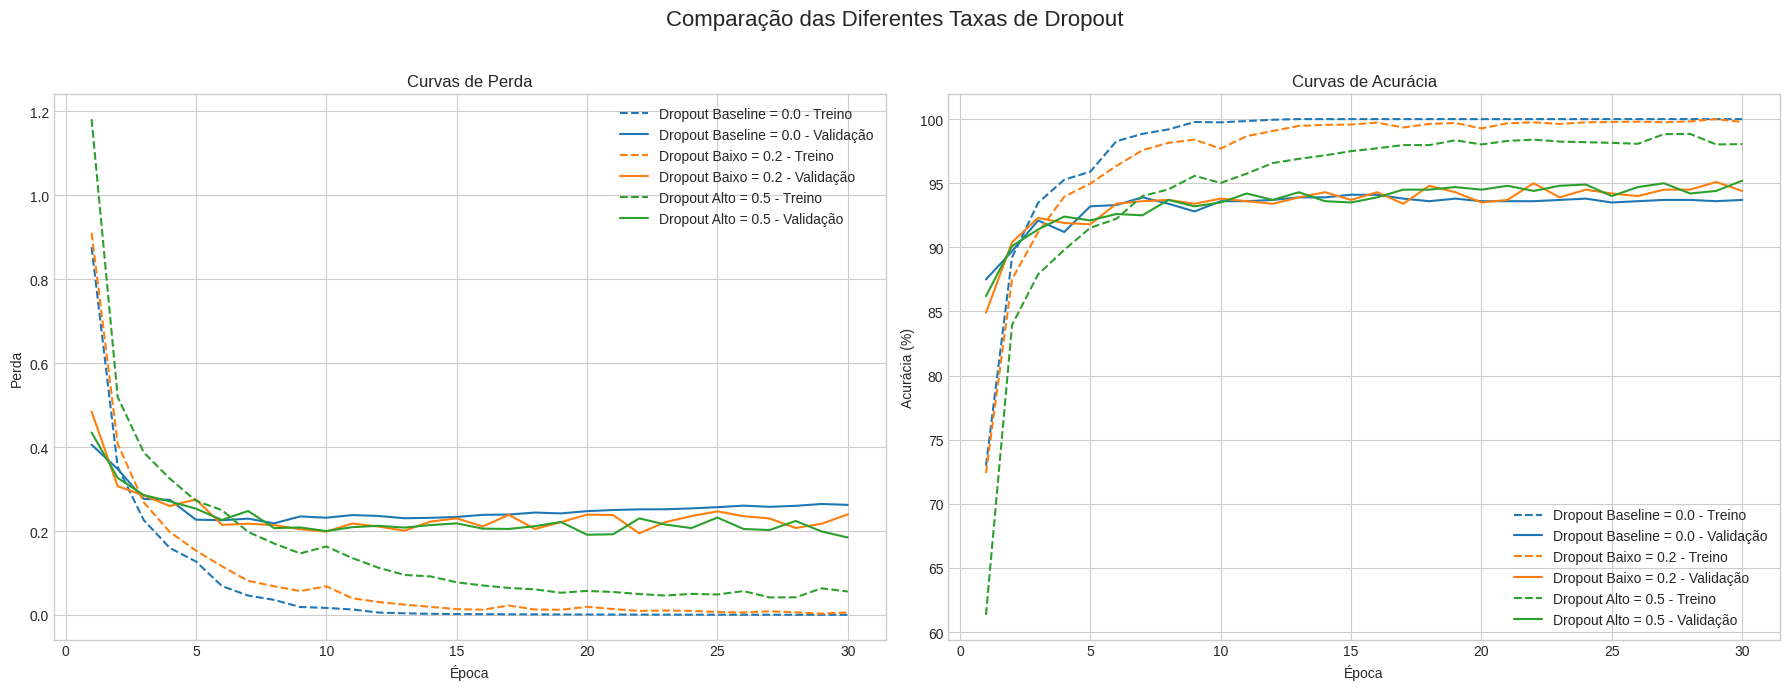

In [25]:
# --- Setup do Experimento 1 ---
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Dicionários
dropout_histories = {}
dropout_rates_to_test = {'Baseline': 0.0, 'Baixo': 0.2, 'Alto': 0.5}

# --- Execução do Experimento 1 ---
for name, dropout_rate in dropout_rates_to_test.items():
    print(f"\n--- Treinando com Dropout {name} = {dropout_rate} ---")
    model = BaseModel(dropout_rate=dropout_rate).to(device)
    history = run_experiment(model, train_loader, val_loader, num_epochs=30)
    dropout_histories[f'Dropout {name} = {dropout_rate}'] = history

# --- Resultados do Experimento 1 ---
plot_learning_curves(dropout_histories, "Comparação das Diferentes Taxas de Dropout")

### Exercício 2: Combinação de Técnicas
Crie um modelo que combine dropout com regularização L2. Compare com os modelos individuais.


--- Treinando com Apenas Dropout ---
Época [1/30] - Train Loss: 1.1721, Train Acc: 61.17% | Val Loss: 0.4384, Val Acc: 86.90%
Época [2/30] - Train Loss: 0.4722, Train Acc: 84.88% | Val Loss: 0.3272, Val Acc: 90.40%
Época [3/30] - Train Loss: 0.3522, Train Acc: 89.45% | Val Loss: 0.2682, Val Acc: 91.60%
Época [4/30] - Train Loss: 0.2820, Train Acc: 90.85% | Val Loss: 0.2521, Val Acc: 92.90%
Época [5/30] - Train Loss: 0.2425, Train Acc: 92.72% | Val Loss: 0.2382, Val Acc: 92.60%
Época [6/30] - Train Loss: 0.2078, Train Acc: 93.78% | Val Loss: 0.2120, Val Acc: 94.10%
Época [7/30] - Train Loss: 0.1839, Train Acc: 94.25% | Val Loss: 0.2404, Val Acc: 93.80%
Época [8/30] - Train Loss: 0.1583, Train Acc: 94.72% | Val Loss: 0.2036, Val Acc: 93.90%
Época [9/30] - Train Loss: 0.1439, Train Acc: 95.65% | Val Loss: 0.1930, Val Acc: 94.80%
Época [10/30] - Train Loss: 0.1268, Train Acc: 95.60% | Val Loss: 0.1999, Val Acc: 94.10%
Época [11/30] - Train Loss: 0.0969, Train Acc: 97.00% | Val Loss: 0.210

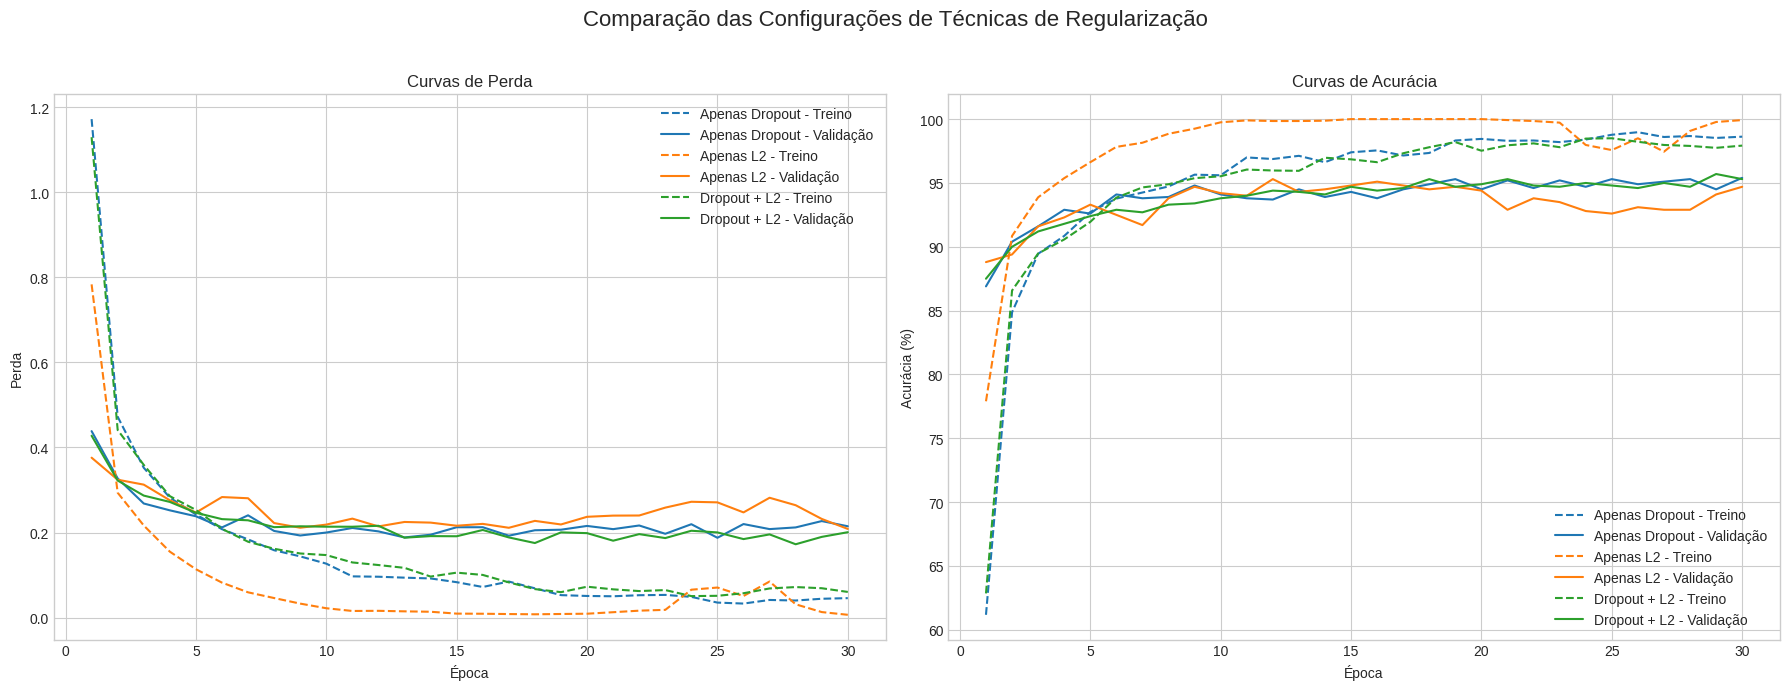

In [26]:
# --- Setup do Experimento 2 ---
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Dicionários
technique_histories = {}
configs = {
    'Apenas Dropout': {'dropout': 0.5, 'l2': 0.0},
    'Apenas L2': {'dropout': 0.0, 'l2': 0.001},
    'Dropout + L2': {'dropout': 0.5, 'l2': 0.001}
}

# --- Execução do Experimento 2 ---
for name, params in configs.items():
    print(f"\n--- Treinando com {name} ---")
    model = BaseModel(dropout_rate=params['dropout']).to(device)
    history = run_experiment(model, train_loader, val_loader, l2_lambda=params['l2'], num_epochs=30)
    technique_histories[name] = history

# --- Resultados do Experimento 2 ---
plot_learning_curves(technique_histories, "Comparação das Configurações de Técnicas de Regularização")

### Exercício 3: Data Augmentation Customizado
Experimente diferentes transformações de data augmentation (veja a documentação do TorchVision).


--- Testando: Baseline (Sem Augmentation) ---
Época [1/30] - Train Loss: 0.8143, Train Acc: 76.38% | Val Loss: 0.3250, Val Acc: 91.80%
Época [2/30] - Train Loss: 0.3071, Train Acc: 90.60% | Val Loss: 0.2695, Val Acc: 92.10%
Época [3/30] - Train Loss: 0.2081, Train Acc: 93.35% | Val Loss: 0.2259, Val Acc: 94.00%
Época [4/30] - Train Loss: 0.1440, Train Acc: 95.65% | Val Loss: 0.2319, Val Acc: 93.40%
Época [5/30] - Train Loss: 0.1045, Train Acc: 96.75% | Val Loss: 0.1937, Val Acc: 93.60%
Época [6/30] - Train Loss: 0.0758, Train Acc: 97.72% | Val Loss: 0.2076, Val Acc: 93.90%
Época [7/30] - Train Loss: 0.0556, Train Acc: 98.30% | Val Loss: 0.1833, Val Acc: 94.50%
Época [8/30] - Train Loss: 0.0342, Train Acc: 99.03% | Val Loss: 0.1846, Val Acc: 95.40%
Época [9/30] - Train Loss: 0.0270, Train Acc: 99.38% | Val Loss: 0.2222, Val Acc: 94.20%
Época [10/30] - Train Loss: 0.0201, Train Acc: 99.58% | Val Loss: 0.2042, Val Acc: 94.60%
Época [11/30] - Train Loss: 0.0121, Train Acc: 99.80% | Val Lo

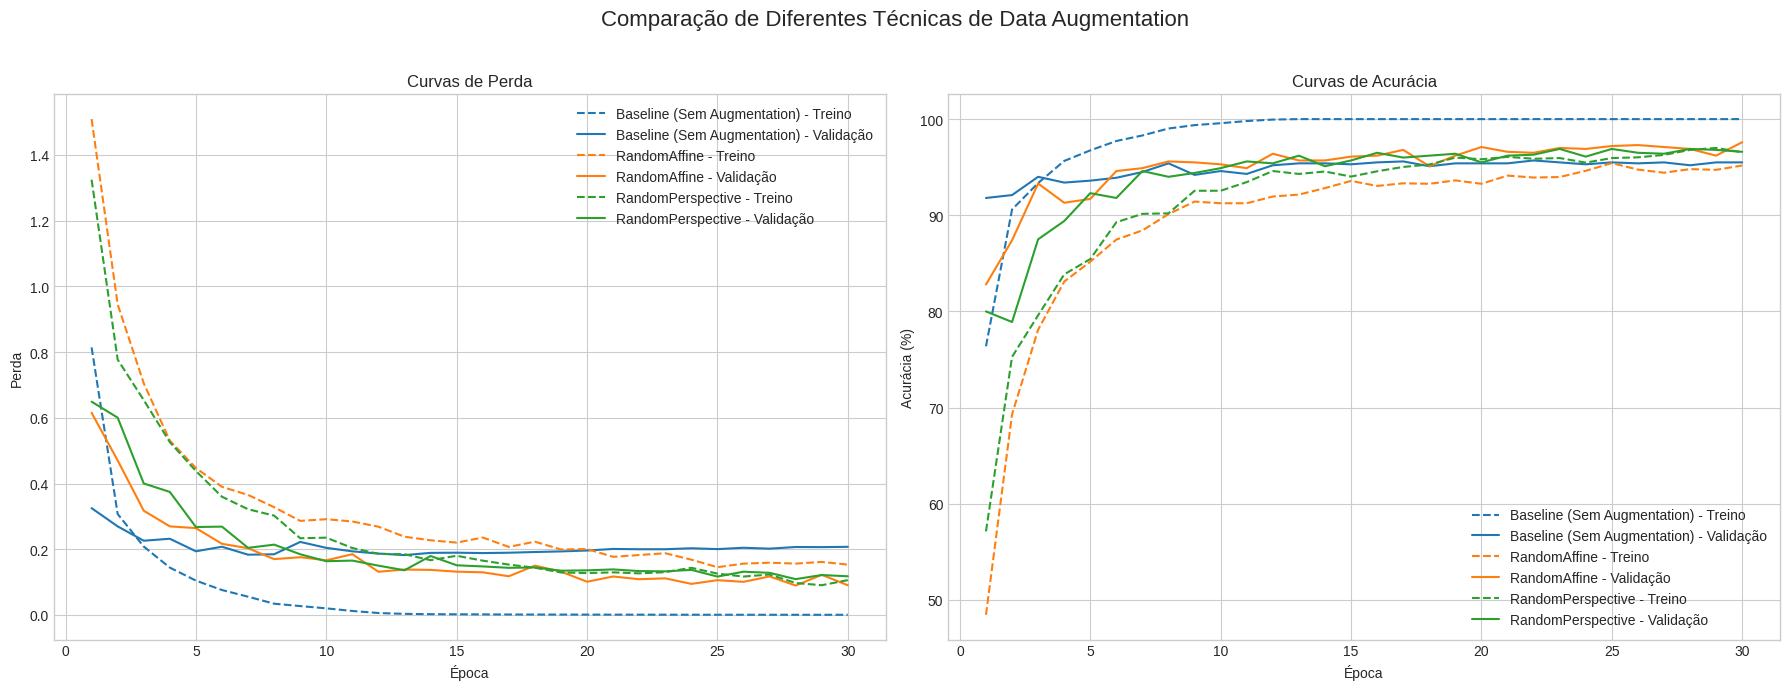

In [27]:
# --- Setup do Experimento 3 ---
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

val_dataset = Subset(full_test_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_dataset_baseline = Subset(full_train_dataset, train_indices)

# Dicionários
augmentation_histories = {}
augmented_datasets_for_viz = {}
transforms_to_test = {
    "Baseline (Sem Augmentation)": transform_base,
    "RandomAffine": transforms.Compose([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    "RandomPerspective": transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
}

# --- Execução do Experimento 3 ---
for name, transform_pipeline in transforms_to_test.items():
    print(f"\n--- Testando: {name} ---")
    train_dataset_aug = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_pipeline)
    train_subset_aug = Subset(train_dataset_aug, train_indices)
    train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True)

    model = BaseModel(dropout_rate=0.0).to(device)
    history = run_experiment(model, train_loader_aug, val_loader, num_epochs=30)
    augmentation_histories[name] = history

# --- Resultados do Experimento 3 ---
plot_learning_curves(augmentation_histories, "Comparação de Diferentes Técnicas de Data Augmentation")

### Exercício 4: Análise de Overfitting
Use um dataset ainda menor (1000 amostras de treino) e compare como cada técnica de regularização se comporta em um cenário de overfitting mais severo.


--- Treinando: Baseline em Dataset Limitado ---
Época [1/30] - Train Loss: 1.2968, Train Acc: 61.80% | Val Loss: 0.6674, Val Acc: 78.30%
Época [2/30] - Train Loss: 0.4558, Train Acc: 84.80% | Val Loss: 0.4669, Val Acc: 84.80%
Época [3/30] - Train Loss: 0.2621, Train Acc: 92.50% | Val Loss: 0.3906, Val Acc: 87.90%
Época [4/30] - Train Loss: 0.1713, Train Acc: 95.60% | Val Loss: 0.3975, Val Acc: 87.20%
Época [5/30] - Train Loss: 0.1191, Train Acc: 97.00% | Val Loss: 0.3939, Val Acc: 87.20%
Época [6/30] - Train Loss: 0.0680, Train Acc: 98.70% | Val Loss: 0.3602, Val Acc: 87.90%
Época [7/30] - Train Loss: 0.0438, Train Acc: 99.10% | Val Loss: 0.3893, Val Acc: 88.30%
Época [8/30] - Train Loss: 0.0355, Train Acc: 99.30% | Val Loss: 0.3788, Val Acc: 89.20%
Época [9/30] - Train Loss: 0.0166, Train Acc: 99.90% | Val Loss: 0.3770, Val Acc: 89.50%
Época [10/30] - Train Loss: 0.0093, Train Acc: 100.00% | Val Loss: 0.3690, Val Acc: 89.20%
Época [11/30] - Train Loss: 0.0057, Train Acc: 100.00% | Va

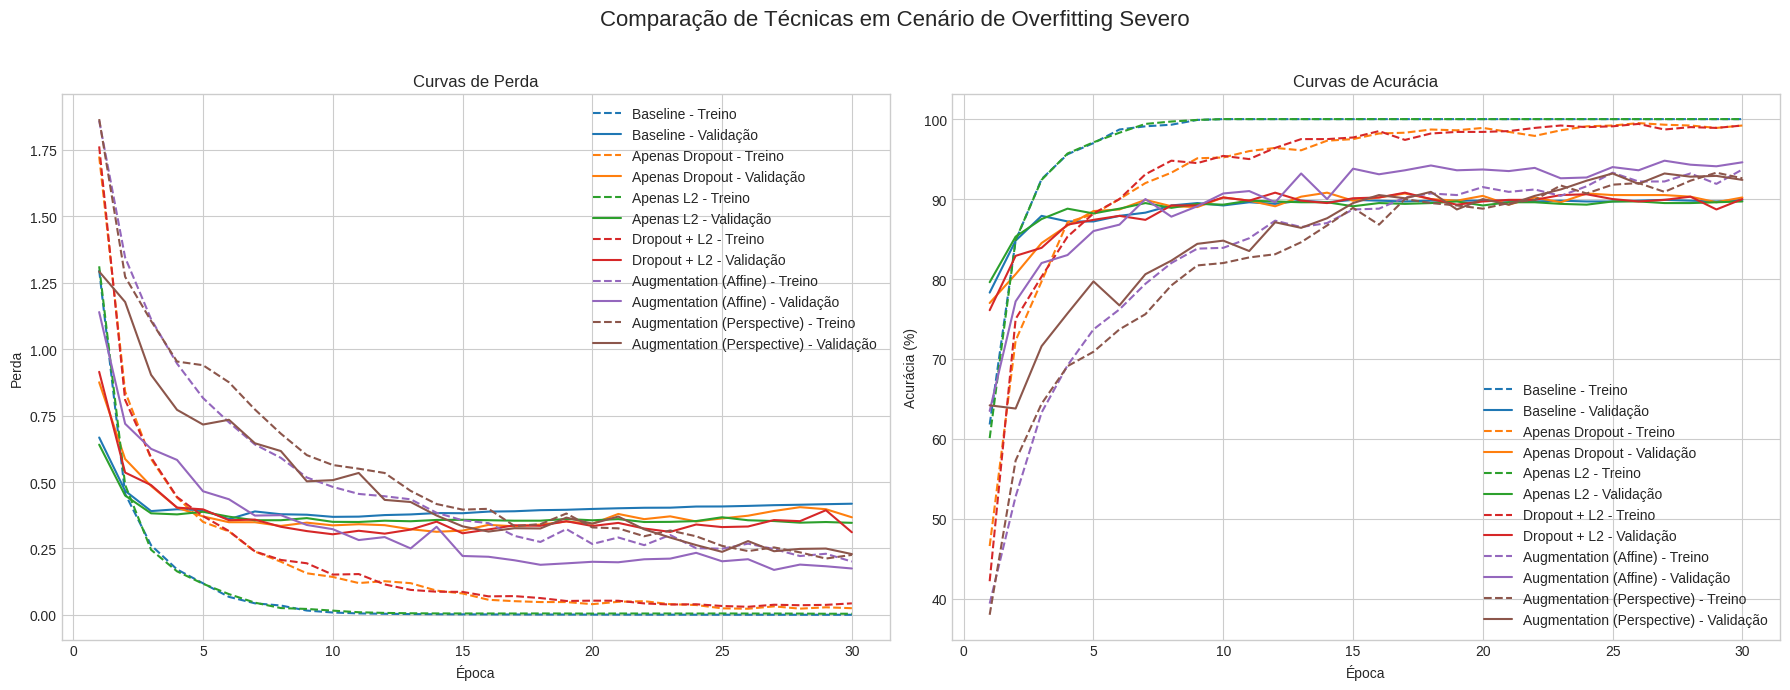

In [28]:
# --- Setup do Experimento 4 ---
train_indices_small = torch.randperm(len(full_train_dataset))[:1000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]
val_dataset = Subset(full_test_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 30

# Loader de Treino Padrão (para Baseline, Dropout, L2)
train_dataset_small = Subset(full_train_dataset, train_indices_small)
train_loader_small = DataLoader(train_dataset_small, batch_size=64, shuffle=True)

# Loader com Augmentation RandomAffine
transform_affine = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset_affine = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_affine)
train_subset_affine = Subset(train_dataset_affine, train_indices_small)
train_loader_affine = DataLoader(train_subset_affine, batch_size=64, shuffle=True)

# Loader com Augmentation RandomPerspective
transform_perspective = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.4, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset_perspective = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_perspective)
train_subset_perspective = Subset(train_dataset_perspective, train_indices_small)
train_loader_perspective = DataLoader(train_subset_perspective, batch_size=64, shuffle=True)

# Dicionários
final_histories = {}
final_configs = {
    "Baseline": {"dropout": 0.0, "l2": 0.0, "loader": train_loader_small},
    "Apenas Dropout": {"dropout": 0.5, "l2": 0.0, "loader": train_loader_small},
    "Apenas L2": {"dropout": 0.0, "l2": 0.001, "loader": train_loader_small},
    "Dropout + L2": {"dropout": 0.5, "l2": 0.001, "loader": train_loader_small},
    "Augmentation (Affine)": {"dropout": 0.0, "l2": 0.0, "loader": train_loader_affine},
    "Augmentation (Perspective)": {"dropout": 0.0, "l2": 0.0, "loader": train_loader_perspective}
}

# --- Execução do Experimento 4 ---
for name, config in final_configs.items():
    print(f"\n--- Treinando: {name} em Dataset Limitado ---")
    model = BaseModel(dropout_rate=config['dropout']).to(device)
    history = run_experiment(model, config['loader'], val_loader, l2_lambda=config['l2'], num_epochs=num_epochs)
    final_histories[name] = history

# --- Resultados do Experimento 4 ---
plot_learning_curves(final_histories, "Comparação de Técnicas em Cenário de Overfitting Severo")

### Conclusões

* Observações (Para validação)
* * No experimento 1 (Taxas de *Dropout*), a aplicação de *dropout* melhorou a acurácia e reduziu a perda final em comparação com o modelo `Baseline`. Isso ocorreu porque o dropout diminuiu o *gap* entre as métricas de treino e validação, forçando o modelo a aprender as features.
* * No experimento 2 (Técnicas de Regularização), o modelo híbrido (`Dropout + L2`) apresentou o melhor desempenho, com a menor perda de validação. Isso indica que a combinação de diferentes abordagens de regularização podem ser mais eficazes do que usá-las isoladamente.
* * No experimento 3 (*Data Augmentation*), ambas as técnicas (*RandomAffine* e *RandomPerspective*) foram muito eficazes. Elas superaram a acurácia de validação do *Baseline* e reduziram o *overfitting*, mantendo as curvas de treino e validação mais próximas.
* * No experimento 4 (*Overfitting* Severo), a eficácia da regularização tornou-se evidente. O modelo *Baseline* falhou em generalizar, enquanto todas as técnicas de regularização ofereceram melhorias. As configurações que envolvem *Data Augmentation* se destacaram como as melhores estratégias para esse caso, alcançando maiores acurácias de validação, menores perdas e indicando que aumentar artificialmente a variedade dos dados é crucial quando as amostras são escassas.